<a href="https://colab.research.google.com/github/baskoroadiw/tugasbesar-visikomputer/blob/master/Tubes_Viskom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tugas Besar Visi Komputer**

Nama Anggota : <br>
- Baskoro Adi Wicaksono (1301208521) <br>
- Devani Paundrianagari Nairda (1301208520) <br>
- Rahmat Tobi Hidayat (1301208530)

# Check GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 23 07:26:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Define Hyperparameter

In [ ]:
# Variable

batch_size = 32
epochs = 100
img_size = 416
model_name = "yolov5s"

# Import & Install

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12270, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 12270 (delta 5), reused 9 (delta 1), pack-reused 12250
Receiving objects: 100% (12270/12270), 12.04 MiB | 32.70 MiB/s, done.
Resolving deltas: 100% (8491/8491), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.1 MB/s 


In [ ]:
pip install -U albumentations opencv-python --quiet

     |████████████████████████████████| 113 kB 5.1 MB/s 
     |████████████████████████████████| 60.9 MB 1.4 MB/s 
     |████████████████████████████████| 48.3 MB 1.5 MB/s 


In [ ]:
import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 39.1/166.8 GB disk)


In [ ]:
import os
import numpy as np
import gdown
from xml.dom.minidom import parse
from pathlib import Path
from shutil import copyfile
import datetime
import matplotlib.image as img
import matplotlib.pyplot as plt

# WANDB

In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 145 kB 52.5 MB/s 
     |████████████████████████████████| 181 kB 54.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download Data

In [ ]:
%cd /content

gdown.download(id='1uhuTpAt8LaSUxJ7yB6NDaCvpWRoxPSnx')

/content


Downloading...
From: https://drive.google.com/uc?id=1uhuTpAt8LaSUxJ7yB6NDaCvpWRoxPSnx
To: /content/kaggle.json
100%|██████████| 66.0/66.0 [00:00<00:00, 60.5kB/s]


'kaggle.json'

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download andrewmvd/hard-hat-detection

 99% 1.21G/1.22G [00:08<00:00, 161MB/s]
100% 1.22G/1.22G [00:08<00:00, 148MB/s]


In [ ]:
! unzip -qq '/content/hard-hat-detection.zip'

# Load & Split Data

In [ ]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [ ]:
classes = ['helmet','head']

In [ ]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [ ]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = 'Dataset/labels/' +  img_jpg_file_name + '.txt'
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            if(box[0] != "person"):

              cls_num = classes.index(box[0])

              new_box = convert_annot(size, box[1:])

              file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [ ]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir('annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('annotations', file_xml[0])

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( 'Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exist")
        os.makedirs(root_file)

    root_file = Path('Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exist")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = 'Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = 'Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, 'Dataset/labels', 'images', "train")
copy_data(val_list,   'Dataset/labels', 'images', "val")
copy_data(test_list,  'Dataset/labels', 'images', "test")

Path Dataset/images/train does not exist
Path Dataset/labels/train does not exist
Path Dataset/images/val does not exist
Path Dataset/labels/val does not exist
Path Dataset/images/test does not exist
Path Dataset/labels/test does not exist


In [ ]:
import yaml

dict_file = {'train':'/content/Dataset/images/train' ,
            'val': '/content/Dataset/images/val',
            'nc' : '2',
            'names' : ['helmet','head']}

with open('/content/yolov5/data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)

# Change hyperparameter for augmentation

In [ ]:
with open('/content/yolov5/data/hyps/hyp.scratch-low.yaml', 'r') as file:
  
  hyp_conf_high = yaml.safe_load(file)

hyp_conf_high

{'anchor_t': 4.0,
 'box': 0.05,
 'cls': 0.5,
 'cls_pw': 1.0,
 'copy_paste': 0.0,
 'degrees': 0.0,
 'fl_gamma': 0.0,
 'fliplr': 0.5,
 'flipud': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'iou_t': 0.2,
 'lr0': 0.01,
 'lrf': 0.01,
 'mixup': 0.0,
 'momentum': 0.937,
 'mosaic': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'perspective': 0.0,
 'scale': 0.5,
 'shear': 0.0,
 'translate': 0.1,
 'warmup_bias_lr': 0.1,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'weight_decay': 0.0005}

In [ ]:
# Change flipud, degrees, and iou_thres

hyp_conf_high['flipud'] = 0.5
hyp_conf_high['degrees'] = 0.3
hyp_conf_high['iou_t'] = 0.5

In [ ]:
with open('/content/yolov5/data/hyps/hyp.scratch-low.yaml', 'w') as file:
    yaml.dump(hyp_conf_high, file)

print(open('/content/yolov5/data/hyps/hyp.scratch-low.yaml').read())

anchor_t: 4.0
box: 0.05
cls: 0.5
cls_pw: 1.0
copy_paste: 0.0
degrees: 0.3
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.5
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
iou_t: 0.5
lr0: 0.01
lrf: 0.01
mixup: 0.0
momentum: 0.937
mosaic: 1.0
obj: 1.0
obj_pw: 1.0
perspective: 0.0
scale: 0.5
shear: 0.0
translate: 0.1
warmup_bias_lr: 0.1
warmup_epochs: 3.0
warmup_momentum: 0.8
weight_decay: 0.0005



# Training

In [ ]:
proj_name = "hard-hat-detection"
run_name = f"{model_name}-model_{epochs}epochs_training"

%cd /content

time_start = datetime.datetime.now()

!python yolov5/train.py \
    --data 'yolov5/data/hard_head.yaml' \
    --weights 'yolov5/models/{model_name}.pt' \
    --batch {batch_size} \
    --epochs {epochs} \
    --img {img_size} \
    --project {proj_name} \
    --name {run_name}

time_stop = datetime.datetime.now()

training_time = time_stop-time_start

print(training_time)

/content
wandb: Currently logged in as: baskoroadi. Use `wandb login --relogin` to force relogin
train: weights=yolov5/models/yolov5s.pt, cfg=, data=yolov5/data/hard_head.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=hard-hat-detection, name=yolov5s-model_100epochs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-253-g75bbaa8 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: anchor_t=4.0, box=0.05, cls=0.5, cls_pw=1.0, copy_paste=0.0, degrees=0.3, fl_

# Preparation for detection and evaluation

In [ ]:
id_wandb = "14j6h14q"

In [ ]:
run = wandb.init(project="hard-hat-detection", entity="baskoroadi", resume="must", id=id_wandb)

wandb: Currently logged in as: baskoroadi. Use `wandb login --relogin` to force relogin


In [ ]:
# Download Weight
run.use_artifact(f'run_{id_wandb}_model:latest').download(root="/content")

'/content'

# Detection

In [ ]:
%cd /content

proj_name = "hard-hat-detection"
run_name = f"{model_name}-model_{epochs}epochs_detection"

!python yolov5/detect.py \
    --source '/content/Dataset/images/test' \
    --weight '/content/best.pt' \
    --project {proj_name} \
    --name {run_name}

/content
detect: weights=['/content/best.pt'], source=/content/Dataset/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=hard-hat-detection, name=yolov5s-model_100epochs, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients
image 1/500 /content/Dataset/images/test/hard_hat_workers1005.png: 640x640 5 helmets, Done. (0.010s)
image 2/500 /content/Dataset/images/test/hard_hat_workers1058.png: 640x640 6 helmets, Done. (0.010s)
image 3/500 /content/Dataset/images/test/hard_hat_workers1061.png: 640x640 3 helmets, Done. (0.011s)
image 4/500 /content

Number: 182


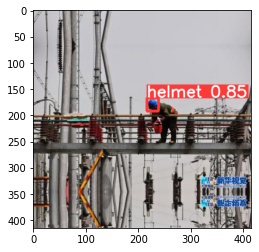

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import random

testfiles = glob(f'{proj_name}/{run_name}/*')

image_number = random.randint(0, len(testfiles))

img = plt.imread(testfiles[image_number])
plt.imshow(img)    
plt.show

print(f"Number: {image_number}")

# Evaluation

In [ ]:
%cd /content

proj_name = "hard-hat-detection"
run_name = f"{model_name}-model_{epochs}epochs_eval"

!python yolov5/val.py \
    --data 'yolov5/data/hard_head.yaml' \
    --img {img_size} \
    --weight '/content/best.pt' \
    --project {proj_name} \
    --name {run_name}

/content
val: data=yolov5/data/hard_head.yaml, weights=['/content/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=hard-hat-detection, name=yolov5s-model_100epochs, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 17.8MB/s]
val: Scanning '/content/Dataset/labels/val' images and labels...500 found, 0 missing, 0 empty, 0 corrupt: 100% 500/500 [00:00<00:00, 1834.93it/s]
val: New cache created: /content/Dataset/labels/val.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 16/16 [00:07<00:00,  2.03it/s]
                 all        500       2548      0.947      0.907      0.962 

# Finish

In [ ]:
wandb.finish(quiet=True)